## Click Prediction Project

Matt Leffers, John Burt

This notebook looks at how a range of proportions of click vs nonclick training samples affect performance of different classifiers.

In this version of the analysis, clicks and nonclicks are separated, then train and test samples are randomly selected from each and finally shuffled.

### Load the data

In [1]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

location='./data/'
clickfilename = 'train'

converters = {"site_id": lambda x: int(x, 16),
              "site_domain": lambda x: int(x, 16),
              "site_category": lambda x: int(x, 16),
              "app_id": lambda x: int(x, 16),
              "app_domain": lambda x: int(x, 16),
              "app_category": lambda x: int(x, 16),
              "device_id": lambda x: int(x, 16),
              "device_model": lambda x: int(x, 16),
              "device_type": lambda x: int(x, 16),
              "device_ip": lambda x: int(x, 16),
             }

clickcsvpath = location+clickfilename+'.csv'
clickpicklepath = location+clickfilename+'.pkl'

try:
    print('reading original pickled data...')
    with open(clickpicklepath, 'rb') as handle:
        data = pickle.load(handle)

except:
    print('error: reading original csv file')
    #Import csv file
    data=pd.read_csv(clickcsvpath, converters=converters) 
    # save data
    with open(clickpicklepath, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


reading original pickled data...


### separate click vs non-click samples

In [3]:
# separate click and no-click records, then shuffle each df
data0 = data[data.click==0].copy().sample(frac=1).reset_index(drop=True) 
data1 = data[data.click==1].copy().sample(frac=1).reset_index(drop=True)
 
print(data0.shape, data1.shape)

(33563901, 24) (6865066, 24)


### generate training and test samples, given a desired proportion of clicks to nonclicks

In [17]:
# extract our X and y variables for training and testing

def get_train_test_samples(data0, data1, propclick, numtrain, numtest):

    # get training data
    data_train = data1[:int(numtrain*propclick)].append(data0[:int(numtrain*(1-propclick))], ignore_index=True)

    # shuffle the training data
    data_train = data_train.sample(frac=1).reset_index(drop=True) 

    # get test data
    data_test1 = data1[numtrain:numtrain+numtest]
    data_test0 = data0[numtrain:numtrain+numtest]

    X_train = data_train[data_train.columns.values[2:]]
    y_train = data_train['click']

    X_test1 = data_test1[data_test1.columns.values[2:]]

    X_test0 = data_test0[data_test0.columns.values[2:]]
    
    return X_train, y_train, X_test0, X_test1


numtrain = 200000
numtest = 100000
propclick = .2

X_train, y_train, X_test0, X_test1 = get_train_test_samples(data0, data1, propclick, numtrain, numtest)

print(X_train.shape, y_train.shape, X_test0.shape, X_test1.shape)

(200000, 22) (200000,) (100000, 22) (100000, 22)


## Plot the effect of different proportions of click vs noclick samples on classifier performance, for several different classifiers.

### AdaBoostClassifier with DecisionTreeClassifier:

10 % click, 90 % no-click: score clicks = 0.009, no-clicks = 0.999
20 % click, 80 % no-click: score clicks = 0.085, no-clicks = 0.986
30 % click, 70 % no-click: score clicks = 0.222, no-clicks = 0.939
40 % click, 60 % no-click: score clicks = 0.474, no-clicks = 0.808
50 % click, 50 % no-click: score clicks = 0.737, no-clicks = 0.607
60 % click, 40 % no-click: score clicks = 0.857, no-clicks = 0.457
70 % click, 30 % no-click: score clicks = 0.937, no-clicks = 0.298
80 % click, 20 % no-click: score clicks = 0.979, no-clicks = 0.162
90 % click, 10 % no-click: score clicks = 0.995, no-clicks = 0.057


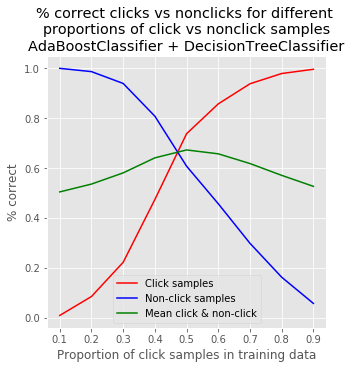

In [18]:
from time import time
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

rng = np.random.RandomState(1)

# Define classifier defaults: 
# define defaults: doing it this way allows us to define our own default params
clf_defaults = {
    'base_estimator' : DecisionTreeClassifier(max_depth=4),
    'n_estimators' : 50, 
    'learning_rate' : .5,
    }

ntrainsamps = 500000
ntestsamps  = 500000

pclicks = []
pc0 = []
pc1 = []
for i in range(1,10):
    clickprop = i/10 # proportion of clicks in training data    
    
    # get the training and test data
    X_train, y_train, X_test0, X_test1 = get_train_test_samples(
        data0, data1, clickprop, ntrainsamps, ntestsamps)
    
    # create the classifier object, using the specified defaults
    clf = AdaBoostClassifier(**clf_defaults, random_state=rng)

    # train the classifier
    clf.fit(X_train, y_train)

    # test the classifier with new all-click and all-nonclick samples
    est_y1 = clf.predict(X_test1)
    est_y0 = clf.predict(X_test0)
    score1 = (est_y1==1).sum() / est_y1.shape[0]
    score0 = (est_y0==0).sum() / est_y0.shape[0]
    
    print("%2.0f %% click, %2.0f %% no-click: score clicks = %1.3f, no-clicks = %1.3f"%(
        100*clickprop, 100*(1-clickprop), score1, score0))

    # collect results for plotting
    pclicks.append(clickprop)
    pc1.append(score1)
    pc0.append(score0)
    
# plot the results
classifiername = 'AdaBoostClassifier + DecisionTreeClassifier'
plt.figure(figsize=(5, 5))
plt.plot(pclicks,pc1,'r-', label='Click samples')
plt.plot(pclicks,pc0,'b-', label='Non-click samples')
plt.plot(pclicks,(np.array(pc0)+np.array(pc1))/2,'g-', label='Mean click & non-click')
plt.title('% correct clicks vs nonclicks for different \nproportions of click vs nonclick samples\n'+classifiername)
plt.xlabel('Proportion of click samples in training data')
plt.ylabel('% correct')
plt.legend();


### SGDClassifier:

10 % click, 90 % no-click: score clicks = 0.015, no-clicks = 0.980
20 % click, 80 % no-click: score clicks = 0.000, no-clicks = 1.000
30 % click, 70 % no-click: score clicks = 0.155, no-clicks = 0.877
40 % click, 60 % no-click: score clicks = 0.940, no-clicks = 0.056
50 % click, 50 % no-click: score clicks = 0.203, no-clicks = 0.869
60 % click, 40 % no-click: score clicks = 0.999, no-clicks = 0.001
70 % click, 30 % no-click: score clicks = 0.986, no-clicks = 0.020
80 % click, 20 % no-click: score clicks = 0.951, no-clicks = 0.069
90 % click, 10 % no-click: score clicks = 0.781, no-clicks = 0.213


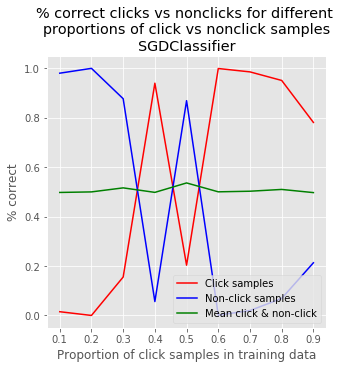

In [19]:
from time import time
from scipy import stats
from sklearn.linear_model import SGDClassifier

# Define Classifier defaults: 
# define defaults: doing it this way allows us to define our own default params
clf_defaults = {
    'loss' : 'log',
    'alpha' : .1, 
    'penalty' : 'l2',
    'max_iter' : 50,
    'tol' : None
    }

ntrainsamps = 500000
ntestsamps  = 500000

pclicks = []
pc0 = []
pc1 = []
for i in range(1,10):
    clickprop = i/10    
        
    clf = SGDClassifier(**clf_defaults)
    
    X_train, y_train, X_test0, X_test1 = get_train_test_samples(
        data0, data1, clickprop, ntrainsamps, ntestsamps)

    clf.fit(X_train, y_train)
    
    est_y1 = clf.predict(X_test1)
    est_y0 = clf.predict(X_test0)
    score1 = (est_y1==1).sum() / est_y1.shape[0]
    score0 = (est_y0==0).sum() / est_y0.shape[0]
    
    print("%2.0f %% click, %2.0f %% no-click: score clicks = %1.3f, no-clicks = %1.3f"%(
        100*clickprop, 100*(1-clickprop), score1, score0))

    pclicks.append(clickprop)
    pc1.append(score1)
    pc0.append(score0)
    
classifiername = 'SGDClassifier'
plt.figure(figsize=(5, 5))
plt.plot(pclicks,pc1,'r-', label='Click samples')
plt.plot(pclicks,pc0,'b-', label='Non-click samples')
plt.plot(pclicks,(np.array(pc0)+np.array(pc1))/2,'g-', label='Mean click & non-click')
plt.title('% correct clicks vs nonclicks for different \nproportions of click vs nonclick samples\n'+classifiername)
plt.xlabel('Proportion of click samples in training data')
plt.ylabel('% correct')
plt.legend();


### XGBoostClassifier:

C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


10 % click, 90 % no-click: score clicks = 0.000, no-clicks = 1.000


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


20 % click, 80 % no-click: score clicks = 0.057, no-clicks = 0.991


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


30 % click, 70 % no-click: score clicks = 0.161, no-clicks = 0.956


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


40 % click, 60 % no-click: score clicks = 0.347, no-clicks = 0.865


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


50 % click, 50 % no-click: score clicks = 0.722, no-clicks = 0.586


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


60 % click, 40 % no-click: score clicks = 0.876, no-clicks = 0.388


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


70 % click, 30 % no-click: score clicks = 0.959, no-clicks = 0.204


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


80 % click, 20 % no-click: score clicks = 0.992, no-clicks = 0.073


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


90 % click, 10 % no-click: score clicks = 0.997, no-clicks = 0.042


C:\Users\john\Anaconda3\envs\datasci\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


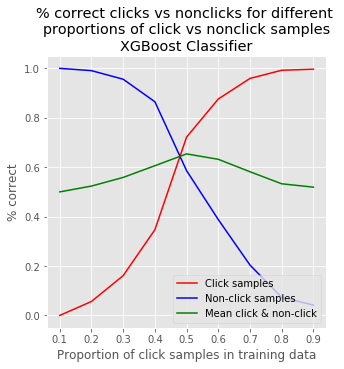

In [21]:
from time import time
from scipy import stats
import xgboost as xgb

# NOTE: the following comment was pasted from some example code:
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {
            'nthread':4, #when use hyperthread, xgboost may become slower
            'objective':'binary:logistic',
            'learning_rate': .2, #so called `eta` value
            'max_depth': 7,
            'min_child_weight': 11,
            'silent': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'n_estimators': 100, #number of trees, change it to 1000 for better results
            'missing':-999,
            }
ntrainsamps = 500000
ntestsamps  = 500000

pclicks = []
pc0 = []
pc1 = []
for i in range(1,10):
    clickprop = i/10    
    
    clf = xgb.XGBClassifier(**clf_defaults)
    
    X_train, y_train, X_test0, X_test1 = get_train_test_samples(
        data0, data1, clickprop, ntrainsamps, ntestsamps)

    clf.fit(X_train, y_train)
    
    est_y1 = clf.predict(X_test1)
    est_y0 = clf.predict(X_test0)
    score1 = (est_y1==1).sum() / est_y1.shape[0]
    score0 = (est_y0==0).sum() / est_y0.shape[0]
    
    print("%2.0f %% click, %2.0f %% no-click: score clicks = %1.3f, no-clicks = %1.3f"%(
        100*clickprop, 100*(1-clickprop), score1, score0))

    pclicks.append(clickprop)
    pc1.append(score1)
    pc0.append(score0)
    
classifiername = 'XGBoost Classifier'
plt.figure(figsize=(5, 5))
plt.plot(pclicks,pc1,'r-', label='Click samples')
plt.plot(pclicks,pc0,'b-', label='Non-click samples')
plt.plot(pclicks,(np.array(pc0)+np.array(pc1))/2,'g-', label='Mean click & non-click')
plt.title('% correct clicks vs nonclicks for different \nproportions of click vs nonclick samples\n'+classifiername)
plt.xlabel('Proportion of click samples in training data')
plt.ylabel('% correct')
plt.legend()